In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tda.activation import TDA

In [2]:
def generate_sine_wave(num_points, frequency, amplitude, phase):
    x = np.linspace(0, 1, num_points)
    y = amplitude * np.sin(2 * np.pi * frequency * x + phase)
    return y

def generate_composite_wave(num_points, frequency1, amplitude1, phase1, frequency2, amplitude2, phase2, noise_std_dev):
    x = np.linspace(0, 1, num_points)
    y1 = amplitude1 * np.sin(2 * np.pi * frequency1 * x + phase1)
    y2 = amplitude2 * np.sin(2 * np.pi * frequency2 * x + phase2)
    noise = np.random.normal(0, noise_std_dev, num_points)
    return y1 + y2 + noise

class SimpleNN(nn.Module):
    def __init__(self, time_window, max_value, scaling_factor, op='mean'):
        super(SimpleNN, self).__init__()
        self.tda_activation = TDA(time_window, max_value, scaling_factor, op=op)

    def forward(self, x):
        return self.tda_activation(x)

In [3]:
num_points = 100

def plot_output(input_data, wave, time_window=20, max_value=10.0, scaling_factor=1.0, op='mean'):
    # Create the neural network with the TDA activation function
    model = SimpleNN(time_window, max_value, scaling_factor, op=op)

    # Generate output data using a sliding window
    output_data = []
    for i in range(num_points - time_window + 1):
        input_window = input_data[..., i:i+time_window]
        output = model(input_window)
        output_data.append(output.item())
    output_data = np.array(output_data)

    # Plot original data and output data
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(wave, label="Input Data (Sine Wave)")
    plt.title("Input Data (Sine Wave)")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(output_data, label="Output Data (TDA Activation)", color='r', lw=2)
    plt.title("Output Data (TDA Activation)")
    plt.legend()

    plt.tight_layout()
    plt.show()

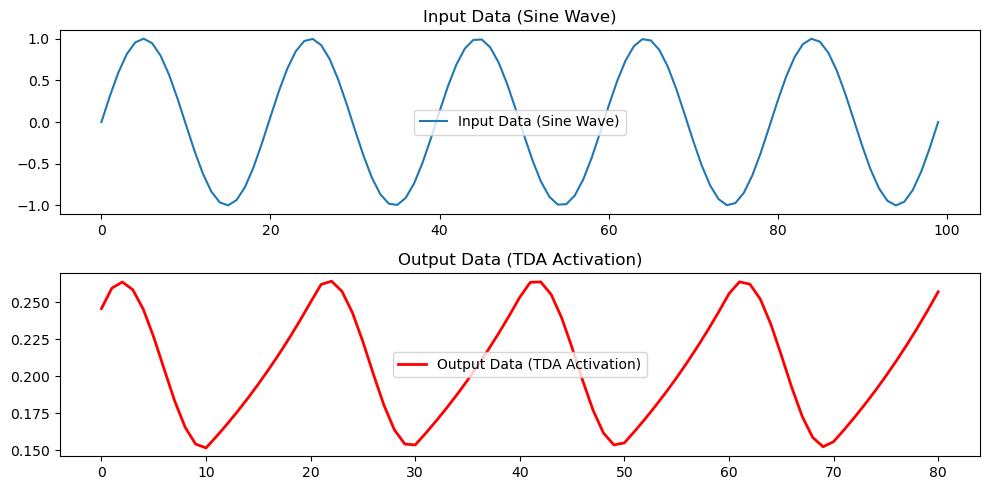

In [4]:
# Generate sine wave
frequency = 5
amplitude = 1
phase = 0

sine_wave = generate_sine_wave(num_points, frequency, amplitude, phase)
input_data = torch.tensor(sine_wave, dtype=torch.float32).view(1, 1, -1)

plot_output(input_data, sine_wave)

## More initeresting example

In this example, we generate a composite wave composed of two sine waves with different frequencies (5 Hz and 15 Hz) and add random Gaussian noise. The TDA activation function is applied to this input signal using a sliding window approach. The input composite wave with noise and the output of the TDA activation function, which reveals the time-dependent effect of the TDA activation function on the input signal.

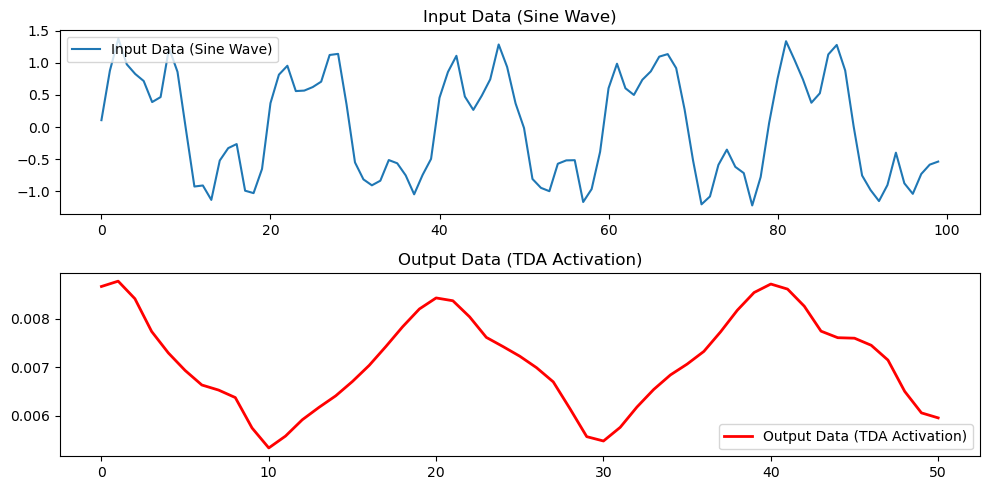

In [5]:
num_points = 100
frequency1 = 5
amplitude1 = 1
phase1 = 0
frequency2 = 15
amplitude2 = 0.5
phase2 = 0
noise_std_dev = 0.2
time_window = 20
max_value = 10.0
scaling_factor = 1.0

# Generate composite wave
composite_wave = generate_composite_wave(num_points, frequency1, amplitude1, phase1, frequency2, amplitude2, phase2, noise_std_dev)
input_data = torch.tensor(composite_wave, dtype=torch.float32).view(1, 1, -1)

plot_output(input_data, composite_wave, time_window=50, max_value=1.0, scaling_factor=0.03, op='mean')

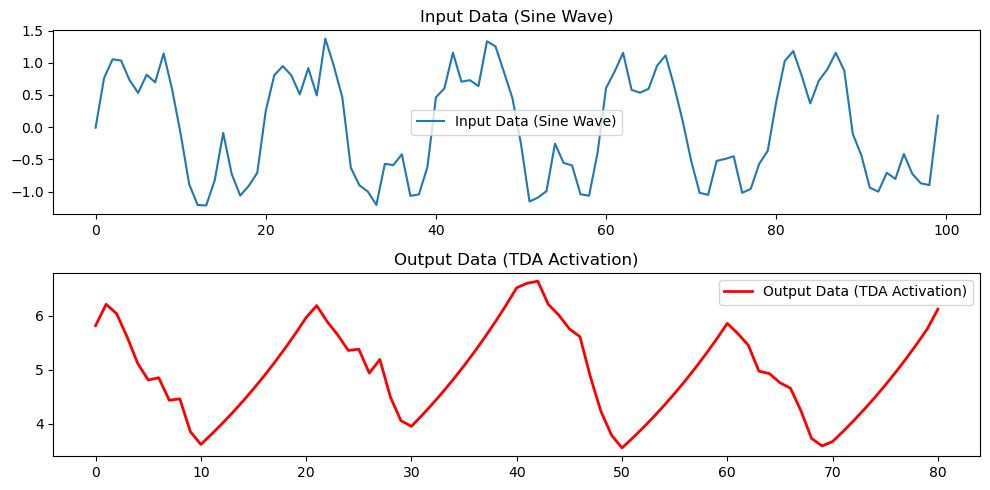

In [6]:
# Generate composite wave
composite_wave = generate_composite_wave(num_points, frequency1, amplitude1, phase1, frequency2, amplitude2, phase2, noise_std_dev)
input_data = torch.tensor(composite_wave, dtype=torch.float32).view(1, 1, -1)

plot_output(input_data, composite_wave, op='sum')

In [7]:
from tda.nn import TDA as TDALayer

class TdaNN(nn.Module):

    def __init__(self, time_window, scaling_factor):
        super(TdaNN, self).__init__()
        self.tda = TDALayer(time_window, scaling_factor)

    def forward(self, x):
        return self.tda(x)
    
input_data = torch.tensor(composite_wave, dtype=torch.float32).view(1, 1, -1)

# Create the neural network with the TDA activation function
model = TdaNN(time_window, scaling_factor)

# Generate output data using a sliding window
output_data = []
for i in range(num_points - time_window + 1):
    input_window = input_data[..., i:i+time_window]
    output = model(input_window)
    output_data.append(output.sum(dim=2))

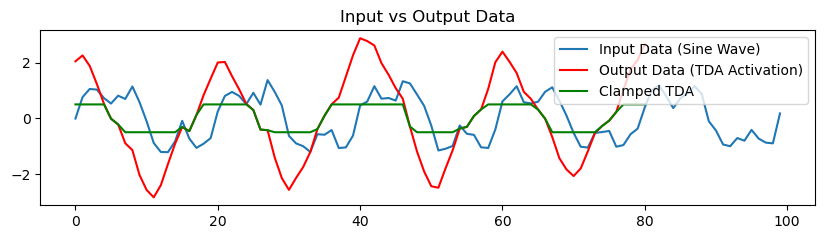

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title("Input vs Output Data")
plt.plot(composite_wave, label="Input Data (Sine Wave)")
plt.plot([d[0][0].item() for d in output_data], label="Output Data (TDA Activation)", color='r')
plt.plot([torch.clamp(d, min=-0.5, max=0.5).item() for d in output_data], label="Clamped TDA", color='g')
plt.legend()
plt.show()

